# FX Volatility Trading

Below is a prototype implementation of an algorithm that produces datasets for profitable strategies selection. The result is a dataset that can be fed into a classification machine learning algorithm to predict whether a variance swap is profitable or not.

## Introduction and Initiation

In [1]:
# Packages, constants and utils:
from algorithm import SPOT_DATA_FILE
from algorithm import VOL_DATA_FILE

from algorithm.utils import (
    FileDef,
    load_csv_data,
    get_index_of_first,
)
from algorithm.stat_methods import (
    calc_annual_realised_vol,
    calc_moving_percentile,
    forecast_ema_vol,
)
from algorithm.trade_classes import VarianceSwap
from algorithm.graphics import PandasHeatMapPlot

import numpy as np
from datetime import timedelta

not_nan = lambda val: not np.isnan(val)
YEAR_WINDOW = 252  # 1Y (in business_days)


First of all, the parameters below can be adjusted in a more generalised algorithm. Since this is just a prototype, we will be assuming that **1-month variance swaps** are traded. A productionisable implementation would accept any tenor. The **percentile volatility window** has also been set for **1 year**, and, although it should be adjustable in a final product, the literature recommends to use this value. Similarly, the **λ** parameter for the Exponential Moving Average (EMA) forecast (see Volatility section) is recommended to be set to 0.97. There is no recommendation regarding the cell divisions, but the chosen ones give a "nice" result. 

In [2]:
# Imputs
swap_window_size = 21  # 1M (in business_days)
percentile_window_size = YEAR_WINDOW
ema_lambda = 0.97

x_cells_in_plot = 20
y_cells_in_plot = 30

T_swap = swap_window_size / YEAR_WINDOW  # (in years)


In [3]:
# Load Market data
file_defs = [
    FileDef(filename=SPOT_DATA_FILE, colname="spot"),
    FileDef(filename=VOL_DATA_FILE, colname="1m_annualised_atmf_vol"),
]
df = load_csv_data(*file_defs)


The loaded data requires dates to be in ascending order for the algorithm below

In [4]:
# Sort loaded data
df.sort_values(by="date", ascending=True, inplace=True)

## Volatilities

For this algorithm, the following data regarding volatilities are required for each date in the dataset:

- 1-month at-the-money implied volatility for each date
    
- 1-month realised volatility forecast from each date into the future
    
- 1-year implied volatility percentile. This is the percentile of the implied volatility at a given date from the set of all the volatilities 1 year in the past.

### 1M ATM Implied Volatility

The first assumption taken in this algorithm is that the provided volatility data is already the 1-month at-the-money implied volatility, and that it is quoted in annualised terms. For this reason, it is convertend into monthly volatilities

In [5]:
# Convert annualised implied vol to monthly vol
df["1m_annualised_atmf_vol"] = df["1m_annualised_atmf_vol"] / 100
df["1m_atmf_vol"] = df["1m_annualised_atmf_vol"] * (swap_window_size / 252) ** 0.5
print(df.head())

           date  spot  1m_annualised_atmf_vol  1m_atmf_vol
3391 2007-11-02   NaN                  0.0720     0.020785
3390 2007-11-05   NaN                  0.0750     0.021651
3389 2007-11-06   NaN                  0.0755     0.021795
3388 2007-11-07   NaN                  0.0880     0.025403
3387 2007-11-08   NaN                  0.0885     0.025548


### 1Y Implied Volatility Percentile
A function has been written to fastly calculate the 1y prcentile volatility at each date (see algorithm/stat_methods.py)

In [6]:
# Calculate implied volatility percentile for a 1-year window
df["1y_implied_vol_percentile"] = np.NaN
df["1y_implied_vol_percentile"] = calc_moving_percentile(
    np.array(df["1m_atmf_vol"]), percentile_window_size
)
print(df.head())

           date  spot  1m_annualised_atmf_vol  1m_atmf_vol  \
3391 2007-11-02   NaN                  0.0720     0.020785   
3390 2007-11-05   NaN                  0.0750     0.021651   
3389 2007-11-06   NaN                  0.0755     0.021795   
3388 2007-11-07   NaN                  0.0880     0.025403   
3387 2007-11-08   NaN                  0.0885     0.025548   

      1y_implied_vol_percentile  
3391                        NaN  
3390                        NaN  
3389                        NaN  
3388                        NaN  
3387                        NaN  


### 1M Realised Volatility Forecast
As recommended in the literature, the volatility is forecasted for a 1-month horizon using an Exponential Moving Average (EMA). The formula is given below:

```
(EMA_t+1)^2 = (EMA_t)^2 * λ + u^2 * (1- λ)
```

where **λ** is a parameter that the literature recommends to be set to 0.97, and u are in our case the monthly logarithmic returns:
```
u_t = ln(P_t / p_(t-1month))
```

In [7]:
# Calculate forecasted 1M realised vol using EMA
start = get_index_of_first(np.array(df["spot"]), not_nan)
first_year_spots = np.array(np.array(df["spot"].iloc[start : start + YEAR_WINDOW]))
vol_0_monthly = calc_annual_realised_vol(first_year_spots) / (
    12 ** 0.5
)  # From annualised to monthly

df["1m_realised_ema_vol_forecast"] = np.NaN
df["1m_realised_ema_vol_forecast"][start:] = forecast_ema_vol(
    levels=np.array(df["spot"].iloc[start:]),
    vol_0=vol_0_monthly,
    window_size=swap_window_size,
    _lambda=ema_lambda
)
print(df.head())

           date  spot  1m_annualised_atmf_vol  1m_atmf_vol  \
3391 2007-11-02   NaN                  0.0720     0.020785   
3390 2007-11-05   NaN                  0.0750     0.021651   
3389 2007-11-06   NaN                  0.0755     0.021795   
3388 2007-11-07   NaN                  0.0880     0.025403   
3387 2007-11-08   NaN                  0.0885     0.025548   

      1y_implied_vol_percentile  1m_realised_ema_vol_forecast  
3391                        NaN                           NaN  
3390                        NaN                           NaN  
3389                        NaN                           NaN  
3388                        NaN                           NaN  
3387                        NaN                           NaN  


/home/carlos/projects/fx-volatility-trading/algorithm/stat_methods.py:10: RuntimeWarning: divide by zero encountered in true_divide
  return np.log((levels / levels_t_minus_s)[window_size:])
/home/carlos/projects/fx-volatility-trading/venv_fx_vol_trad/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Since some ofthecalculations require a window in the past(logarithmic monthly returns require a window of one month, percentile window requires a wondow of 1 year), and the spot and vol market data provided have different sizes, NaN values are introduced in the datafrae, which need to be cleaned.

In [8]:
# Remove null values araising from window discrepancies
df.dropna(inplace=True)
print(df.head())

           date    spot  1m_annualised_atmf_vol  1m_atmf_vol  \
3129 2008-11-04  1.2981                0.240725     0.069491   
3128 2008-11-05  1.2954                0.237925     0.068683   
3127 2008-11-06  1.2715                0.246675     0.071209   
3126 2008-11-07  1.2718                0.234675     0.067745   
3125 2008-11-10  1.2748                0.217075     0.062664   

      1y_implied_vol_percentile  1m_realised_ema_vol_forecast  
3129                   0.968254                      0.041122  
3128                   0.964286                      0.040657  
3127                   0.968254                      0.040113  
3126                   0.952381                      0.039507  
3125                   0.944444                      0.039050  


## Ideal trade mocking
For a real machine learning algorithm, real-trade data would be ideally used to be able to train a model to predict their profitability. However, this was not provided and we will therefore pretend that a 1-month variance swap was traded on each date. Each of these trades will be an ideal trade stroke at the fair price for each date.

Each trade will have a fair strike **K_fair**, with a variance notional of 1, and will be maturing in 1M from the trade date. For this, K_fair is calculated using a rule-of-thumb described Bassu-Strasser-Guichard Varswap paper.

unfortunately, there is no enough market data to estimate this value, as the volatility skew is required. It would have been possible to calculate it if more volatilities from the volatility surface were provided (more specifically, if volatilities for the same tenor and different deltas were provided). Although not a fair assumption, we will assume for this exercise that the volatility is constant with the currency price when at-the-money.

In [9]:
skew_slope = 0

The chunk of code below is in charge of creating a trade on each date, calculate the actual (not forecasted) final, realised volatility, and use it to calculate the payoff. As it may be seen, this piece of code is very inefficient. A better implementation was not done due to lack of time, but also because it also offers a clear picture of what is happening. Proper productionisable implementation would likely involve array operations rather than brute-force looping.

In [10]:
# TODO: loop below is tremendously inefficient. Implement efficient algorithm
latest_date = df["date"].max()
fair_trades = [np.NaN] * df.shape[0]
payoffs = [np.NaN] * df.shape[0]

for indx, pair in enumerate(df.iterrows()):
    row = pair[1]
    if np.isnan(row["1m_atmf_vol"]) or np.isnan(row["spot"]):
        continue
    fair_strike = VarianceSwap.estimate_fair_strike(
        row["1m_annualised_atmf_vol"], T=T_swap, skew_slope=skew_slope
    )

    trade = VarianceSwap(
        direction="buy",
        underlying="EURUSD",
        trade_date=row["date"],
        value_date=row["date"] + timedelta(days=round(365 * T_swap)),
        strike=fair_strike,
        vega_amount=1,
    )
    fair_trades[indx] = trade

    # Take the exact dates at which the trade was valued. Not just a fixed window
    # We assume that the trade date does not count as valuation, but the value date
    # does.
    dates_in_trade = (df["date"] > trade.trade_date) & (df["date"] <= trade.value_date)
    levels = np.array(df.loc[dates_in_trade, "spot"])

    # If the expiry date later than the latest date in the dataframe, then break
    if latest_date < trade.value_date:
        break
    final_realised_vol = VarianceSwap.calc_final_realised_vol(levels)
    payoffs[indx] = trade.payoff(final_realised_vol)

df["fair_trade"] = fair_trades
df["payoff"] = payoffs
df["profitable"] = df["payoff"] > 0
print(df[["fair_trade", "profitable"]].head())

/home/carlos/projects/fx-volatility-trading/algorithm/stat_methods.py:10: RuntimeWarning: divide by zero encountered in true_divide
  return np.log((levels / levels_t_minus_s)[window_size:])


                                             fair_trade  profitable
3129  EURUSD: buy 1@0.24072500000000002 | 2008-11-04...       False
3128  EURUSD: buy 1@0.237925 | 2008-11-05 00:00:00 -...       False
3127  EURUSD: buy 1@0.246675 | 2008-11-06 00:00:00 -...       False
3126  EURUSD: buy 1@0.23467500000000002 | 2008-11-07...       False
3125  EURUSD: buy 1@0.217075 | 2008-11-10 00:00:00 -...       False


## Volatility Carry
Finally, the last value required to input into the machine learning classification algorithm is the volatility carry, which is defined as below:

In [11]:
# Calculate Vol Carry and mark trades that are profitable for each trade date
df["vol_carry"] = df["1m_atmf_vol"] - df["1m_realised_ema_vol_forecast"]

## Plotting the results
Now that we have all the required input values (1y- vol perventile and vol carry), and expected output (profitable trade), we proceed to group the data into buckets to see the **hit rate**. This grouping consists in dividing the vol percentile - vol carry plane into a grid and fitting the traded swaps inside their corresponding cell. The hit rate for each cell is calculated as the ratio between profitable and total number of trades. Custom class `PandasHeatMapPlot` takes care of this:

/home/carlos/projects/fx-volatility-trading/algorithm/graphics.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  str(gridise(row[xcolname], row[ycolname])) for _, row in df.iterrows()


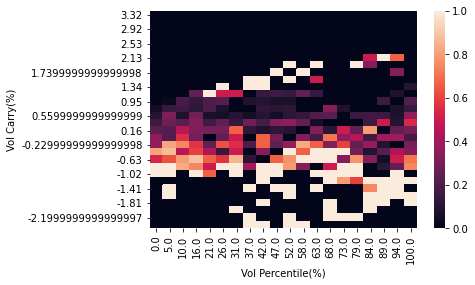

In [12]:
# Plot heatmap
plot_cols = ["1y_implied_vol_percentile", "vol_carry", "profitable"]
plot = PandasHeatMapPlot(df[plot_cols], x_cells_in_plot, y_cells_in_plot, *plot_cols)
plot.show(
    xlabel="Vol Percentile(%)",
    ylabel="Vol Carry(%)",
)